# 1. Data *Upload*

In [1]:
!pip install xgboost lightgbm
!pip install imbalanced-learn shap
!pip install tableone

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.4 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
np.random.seed(42)
random.seed(42)

# Modeling - Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    ExtraTreesClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier
)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from scipy.stats import mannwhitneyu, chi2_contingency

# Preprocessing
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Evaluation metrics
from sklearn.metrics import (
    confusion_matrix, classification_report,
    precision_recall_curve, roc_curve, roc_auc_score, f1_score,
    precision_score, recall_score, auc
)

# Statistical analysis
import statsmodels.api as sm
from tableone import TableOne

# Model interpretation
import shap

# File handling (Colab)
from google.colab import files
import io
from PIL import Image
from IPython.display import display

In [3]:
# Upload training dataset
uploaded = files.upload()

Saving CPE_training_dataset_2022.xlsx to CPE_training_dataset_2022.xlsx


In [4]:
train_df = pd.read_excel("CPE_training_dataset_2022.xlsx")

In [5]:
# Upload validation dataset
uploaded = files.upload()

Saving CPE_validation_dataset_2023.xlsx to CPE_validation_dataset_2023.xlsx


In [6]:
val_df = pd.read_excel("CPE_validation_dataset_2023.xlsx")

In [7]:
# Quick check
print("Training Set (2022):", train_df.shape)
print("Validation Set (2023):", val_df.shape)

# Preview training data
train_df.head()

Training Set (2022): (1992, 43)
Validation Set (2023): (2923, 43)


CPE  Sex  Age  Hospital days before ICU admission  Admission source  \
0    0    0   79                                   2                 2   
1    0    0   64                                   1                 2   
2    0    0   89                                   8                 2   
3    0    0   66                                   6                 1   
4    0    1   77                                   2                 2   

   Previous hospitalization  Preexisting medical condition  Diabetes mellitus  \
0                         1                              1                  1   
1                         1                              1                  0   
2                         1                              1                  0   
3                         1                              1                  0   
4                         1                              0                  0   

   Chronic renal disease  ESRD on renal replacement therapy  ...  \
0                      0                                  0  ...   
1                      0                                  0  ...   
2                      0                                  0  ...   
3                      0                                  0  ...   
4                      0                                  0  ...   

   Previous antibiotic  Fluoroquinolone  Cephalosporin  Carbapenem  \
0                    0                0              0           0   
1                    0                0              0           0   
2                    0                0              0           0   
3                    1                1              0           0   
4                    0                0              0           0   

   β-lactam/β-lactamase inhibitor  Aminoglycoside  \
0                               0               0   
1                               0               0   
2                               0               0   
3                               1               0   
4                               0               0   

   Admission to long-term care facility  VRE  MDRO  Endoscopy  
0                                     0    0     0          0  
1                                     0    0     0          0  
2                                     0    0     0          0  
3                                     0    0     0          0  
4                                     0    0     0          0  

[5 rows x 43 columns]

# 2. Pre-processing

In [8]:
# Target column
target_col = 'CPE'

# Split features and labels
X_train = train_df.drop(columns=[target_col])
y_train = train_df[target_col]

X_val = val_df.drop(columns=[target_col])
y_val = val_df[target_col]

# One-hot encode categorical variables
categorical_vars = ['Admission source']
X_train = pd.get_dummies(X_train, columns=categorical_vars, drop_first=True)
X_val = pd.get_dummies(X_val, columns=categorical_vars, drop_first=True)

# Align validation set columns with training set
X_val = X_val.reindex(columns=X_train.columns, fill_value=0)

# Shape check
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

X_train shape: (1992, 42)
y_train shape: (1992,)
X_val shape: (2923, 42)
y_val shape: (2923,)


# 3. Feature Scaling

In [9]:
# Initialize scaler and fit on training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Convert back to DataFrame to preserve column names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns)

# Shape check
print("X_train_scaled shape:", X_train_scaled.shape)
print("X_val_scaled shape:", X_val_scaled.shape)

X_train_scaled shape: (1992, 42)
X_val_scaled shape: (2923, 42)


# 4. Model Setup

In [10]:
# Models that require scaled input
scaled_models = [
    "Logistic Regression",
    "SVM (RBF)",
    "K-Nearest Neighbors"
]

# Define list of models (name, instance)
models = [
    ("Logistic Regression", LogisticRegression(max_iter=1000, random_state=42)),
    ("Decision Tree", DecisionTreeClassifier(random_state=42)),
    ("Random Forest", RandomForestClassifier(random_state=42)),
    ("Extra Trees", ExtraTreesClassifier(random_state=42)),
    ("XGBoost", XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)),
    ("LightGBM", LGBMClassifier(random_state=42)),
    ("Gradient Boosting", GradientBoostingClassifier(random_state=42)),
    ("AdaBoost", AdaBoostClassifier(random_state=42)),
    ("SVM (RBF)", SVC(kernel='rbf', probability=True, random_state=42)),
    ("K-Nearest Neighbors", KNeighborsClassifier())
]


# 5. Model Training and Evaluation

In [11]:
# Store model performance results
results = []

# Train and evaluate each model
for name, model in models:
    print(f"Training {name}...")

    # Use scaled data if required
    if name in scaled_models:
        X_tr, X_val_used = X_train_scaled, X_val_scaled
    else:
        X_tr, X_val_used = X_train, X_val

    # Train the model and make predictions
    model.fit(X_tr, y_train)
    y_pred_prob = model.predict_proba(X_val_used)[:, 1]
    y_pred = model.predict(X_val_used)

    # Calculate performance metrics
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
    accuracy = round((tp + tn) / (tp + tn + fp + fn), 3)
    sensitivity = round(recall_score(y_val, y_pred, zero_division=0), 3)
    specificity = round(tn / (tn + fp + 1e-8), 3)
    precision = round(precision_score(y_val, y_pred, zero_division=0), 3)
    npv = round(tn / (tn + fn + 1e-8), 3)
    f1 = round(f1_score(y_val, y_pred), 3)
    roc_auc = round(roc_auc_score(y_val, y_pred_prob), 3)
    precision_vals, recall_vals, _ = precision_recall_curve(y_val, y_pred_prob)
    pr_auc = round(auc(recall_vals, precision_vals), 3)

    # Append the results
    results.append({
        "Model": name,
        "Accuracy": accuracy,
        "Sensitivity": sensitivity,
        "Specificity": specificity,
        "PPV": precision,
        "NPV": npv,
        "F1 Score": f1,
        "ROC-AUC": roc_auc,
        "PR-AUC": pr_auc
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Define the desired model order
model_order = [
    "Logistic Regression",
    "Decision Tree",
    "Random Forest",
    "Extra Trees",
    "XGBoost",
    "LightGBM",
    "Gradient Boosting",
    "AdaBoost",
    "SVM (RBF)",
    "K-Nearest Neighbors"
]

# Sort models according to predefined order
results_df["Order"] = results_df["Model"].apply(lambda x: model_order.index(x) if x in model_order else len(model_order))
results_df = results_df.sort_values("Order").drop(columns="Order").reset_index(drop=True)

# Final column order
final_columns = ["Model", "PR-AUC", "ROC-AUC", "F1 Score", "Sensitivity", "Specificity", "PPV", "NPV", "Accuracy"]
results_df = results_df[final_columns]

# Save to Excel
results_df.to_excel("1_model_performance_results_without_smote.xlsx", index=False)

# Display the results
results_df


Training Logistic Regression...
Training Decision Tree...
Training Random Forest...
Training Extra Trees...
Training XGBoost...
Training LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 220, number of negative: 1772


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:43:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000936 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 168
[LightGBM] [Info] Number of data points in the train set: 1992, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.110442 -> initscore=-2.086237
[LightGBM] [Info] Start training from score -2.086237
Training Gradient Boosting...
Training AdaBoost...
Training SVM (RBF)...
Training K-Nearest Neighbors...


Model  PR-AUC  ROC-AUC  F1 Score  Sensitivity  Specificity  \
0  Logistic Regression   0.263    0.766     0.251        0.185        0.975   
1        Decision Tree   0.280    0.600     0.237        0.318        0.882   
2        Random Forest   0.235    0.754     0.188        0.124        0.983   
3          Extra Trees   0.199    0.744     0.212        0.172        0.961   
4              XGBoost   0.216    0.717     0.276        0.253        0.950   
5             LightGBM   0.247    0.743     0.279        0.240        0.958   
6    Gradient Boosting   0.284    0.771     0.311        0.258        0.965   
7             AdaBoost   0.206    0.744     0.131        0.082        0.986   
8            SVM (RBF)   0.237    0.716     0.110        0.064        0.991   
9  K-Nearest Neighbors   0.226    0.676     0.242        0.180        0.973   

     PPV    NPV  Accuracy  
0  0.394  0.932     0.912  
1  0.189  0.937     0.837  
2  0.387  0.928     0.914  
3  0.278  0.931     0.898  
4  0.304  0.936     0.894  
5  0.331  0.936     0.901  
6  0.392  0.938     0.909  
7  0.333  0.925     0.914  
8  0.385  0.924     0.917  
9  0.368  0.932     0.910

In [12]:
files.download("1_model_performance_results_without_smote.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 6. Class Imbalance Handling with SMOTE

In [13]:
# Apply SMOTE to the scaled training data
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train_scaled, y_train)

print("Before:", y_train.value_counts().to_dict())
print("After:", pd.Series(y_train_sm).value_counts().to_dict())

# Initialize results list
smote_results = []

# Train and evaluate each model on SMOTE-applied data
for name, model in models:
    print(f"Training with SMOTE: {name}")

    # Use SMOTE-augmented scaled data for all models
    X_tr, X_val_used = X_train_sm, X_val_scaled

    model.fit(X_tr, y_train_sm)
    y_pred_prob = model.predict_proba(X_val_used)[:, 1]
    y_pred = model.predict(X_val_used)

    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
    accuracy = round((tp + tn) / (tp + tn + fp + fn), 3)
    sensitivity = round(tp / (tp + fn + 1e-8), 3)
    specificity = round(tn / (tn + fp + 1e-8), 3)
    precision = round(tp / (tp + fp + 1e-8), 3)
    npv = round(tn / (tn + fn + 1e-8), 3)
    f1 = round(f1_score(y_val, y_pred), 3)
    roc_auc = round(roc_auc_score(y_val, y_pred_prob), 3)
    precision_vals, recall_vals, _ = precision_recall_curve(y_val, y_pred_prob)
    pr_auc = round(auc(recall_vals, precision_vals), 3)

    smote_results.append({
        "Model": name,
        "Accuracy": accuracy,
        "Sensitivity": sensitivity,
        "Specificity": specificity,
        "PPV": precision,
        "NPV": npv,
        "F1 Score": f1,
        "ROC-AUC": roc_auc,
        "PR-AUC": pr_auc
    })

# Create DataFrame
smote_df = pd.DataFrame(smote_results)

# Desired model order
model_order = [
    "Logistic Regression",
    "Decision Tree",
    "Random Forest",
    "Extra Trees",
    "XGBoost",
    "LightGBM",
    "Gradient Boosting",
    "AdaBoost",
    "SVM (RBF)",
    "K-Nearest Neighbors"
]

# Sort by custom order
smote_df["Order"] = smote_df["Model"].apply(lambda x: model_order.index(x) if x in model_order else len(model_order))
smote_df = smote_df.sort_values("Order").drop(columns="Order").reset_index(drop=True)

# Reorder columns
final_cols = ["Model", "PR-AUC", "ROC-AUC", "F1 Score", "Sensitivity", "Specificity", "PPV", "NPV", "Accuracy"]
smote_df = smote_df[final_cols]

# Save as Excel file
smote_df.to_excel("2_model_performance_results_with_smote.xlsx", index=False)

# Preview the results
smote_df

Before: {0: 1772, 1: 220}
After: {0: 1772, 1: 1772}
Training with SMOTE: Logistic Regression
Training with SMOTE: Decision Tree
Training with SMOTE: Random Forest
Training with SMOTE: Extra Trees
Training with SMOTE: XGBoost


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:43:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training with SMOTE: LightGBM
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1772, number of negative: 1772
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000858 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3833
[LightGBM] [Info] Number of data points in the train set: 3544, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training with SMOTE: Gradient Boosting
Training with SMOTE: AdaBoost
Training with SMOTE: SVM (RBF)
Training with SMOTE: K-Nearest Neighbors


Model  PR-AUC  ROC-AUC  F1 Score  Sensitivity  Specificity  \
0  Logistic Regression   0.228    0.743     0.270        0.661        0.719   
1        Decision Tree   0.289    0.606     0.244        0.335        0.878   
2        Random Forest   0.174    0.737     0.184        0.159        0.951   
3          Extra Trees   0.185    0.739     0.245        0.227        0.945   
4              XGBoost   0.202    0.700     0.264        0.266        0.935   
5             LightGBM   0.218    0.723     0.260        0.249        0.942   
6    Gradient Boosting   0.226    0.732     0.257        0.253        0.938   
7             AdaBoost   0.211    0.732     0.274        0.412        0.862   
8            SVM (RBF)   0.142    0.682     0.227        0.373        0.835   
9  K-Nearest Neighbors   0.250    0.683     0.249        0.562        0.744   

     PPV    NPV  Accuracy  
0  0.169  0.961     0.715  
1  0.192  0.938     0.835  
2  0.218  0.929     0.887  
3  0.265  0.934     0.888  
4  0.262  0.936     0.882  
5  0.271  0.935     0.887  
6  0.261  0.935     0.883  
7  0.206  0.944     0.826  
8  0.164  0.939     0.798  
9  0.160  0.952     0.730

In [14]:
files.download("2_model_performance_results_with_smote.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 7. Univariate Logistic Regression and Feature Selection

In [15]:
# Set target variable
target_col = 'CPE'
X = train_df.drop(columns=[target_col])
y = train_df[target_col]

# One-hot encode categorical features
X = pd.get_dummies(X, drop_first=True)

# Univariate logistic regression for feature selection
significant_vars = []
for col in X.columns:
    X_const = sm.add_constant(X[col])
    model = sm.Logit(y, X_const).fit(disp=False)
    if model.pvalues[1] < 0.05:
        significant_vars.append(col)

# Filter selected features
X_train_uni = X[significant_vars]
y_train_uni = y

# Validation set preprocessing
X_val_uni = val_df.drop(columns=[target_col])
X_val_uni = pd.get_dummies(X_val_uni, drop_first=True)
X_val_uni = X_val_uni.reindex(columns=X_train_uni.columns, fill_value=0)
y_val_uni = val_df[target_col]

# Feature scaling
scaler_uni = StandardScaler()
X_train_uni_scaled = scaler_uni.fit_transform(X_train_uni)
X_val_uni_scaled = scaler_uni.transform(X_val_uni)

# Train logistic regression model
lr_uni = LogisticRegression(max_iter=1000)
lr_uni.fit(X_train_uni_scaled, y_train_uni)

# Prediction and evaluation
y_pred = lr_uni.predict(X_val_uni_scaled)
y_prob = lr_uni.predict_proba(X_val_uni_scaled)[:, 1]

precision, recall, _ = precision_recall_curve(y_val_uni, y_prob)
pr_auc = round(auc(recall, precision), 3)
roc_auc = round(roc_auc_score(y_val_uni, y_prob), 3)

print("\nClassification Report:")
print(classification_report(y_val_uni, y_pred))
print(f"PR-AUC: {pr_auc}")
print(f"ROC-AUC: {roc_auc}")


Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      2690
           1       0.38      0.17      0.24       233

    accuracy                           0.91      2923
   macro avg       0.66      0.57      0.59      2923
weighted avg       0.89      0.91      0.90      2923

PR-AUC: 0.277
ROC-AUC: 0.782


<ipython-input-15-04b9895c0ab9>:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if model.pvalues[1] < 0.05:
<ipython-input-15-04b9895c0ab9>:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if model.pvalues[1] < 0.05:
<ipython-input-15-04b9895c0ab9>:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if model.pvalues[1] < 0.05:
<ipython-input-15-04b9895c0ab9>:14: FutureWarning: Series.__getitem__ treating keys as positions is deprec

# 7-1. Evaluate Univariate Logistic Regression (No SMOTE)

In [16]:
# Predictions
y_pred = lr_uni.predict(X_val_uni_scaled)
y_prob = lr_uni.predict_proba(X_val_uni_scaled)[:, 1]

# Confusion matrix
tn, fp, fn, tp = confusion_matrix(y_val_uni, y_pred).ravel()

# Evaluation metrics
accuracy = round((tp + tn) / (tp + tn + fp + fn), 3)
sensitivity = round(tp / (tp + fn + 1e-8), 3)
specificity = round(tn / (tn + fp + 1e-8), 3)
precision = round(tp / (tp + fp + 1e-8), 3)
npv = round(tn / (tn + fn + 1e-8), 3)
f1 = round(f1_score(y_val_uni, y_pred), 3)
roc_auc = round(roc_auc_score(y_val_uni, y_prob), 3)

precision_vals, recall_vals, _ = precision_recall_curve(y_val_uni, y_prob)
pr_auc = round(auc(recall_vals, precision_vals), 3)

# Save results with custom order
univariate_lr_results = {
    "Model": "Univariate Logistic Regression (No SMOTE)",
    "PR-AUC": pr_auc,
    "ROC-AUC": roc_auc,
    "F1 Score": f1,
    "Sensitivity": sensitivity,
    "Specificity": specificity,
    "PPV": precision,
    "NPV": npv,
    "Accuracy": accuracy
}

# Print results
for k in ["Model", "PR-AUC", "ROC-AUC", "F1 Score", "Sensitivity", "Specificity", "PPV", "NPV", "Accuracy"]:
    print(f"{k}: {univariate_lr_results[k]}")


Model: Univariate Logistic Regression (No SMOTE)
PR-AUC: 0.277
ROC-AUC: 0.782
F1 Score: 0.237
Sensitivity: 0.172
Specificity: 0.976
PPV: 0.381
NPV: 0.932
Accuracy: 0.912


In [17]:
result_df = pd.DataFrame([univariate_lr_results])
result_df.to_excel("3_univariate_lr_no_smote_results.xlsx", index=False)

files.download("3_univariate_lr_no_smote_results.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 7-2. Evaluate Univariate Logistic Regression (with SMOTE)


In [18]:
# Reconstruct dataset with significant variables
X_uni = train_df.drop(columns=['CPE'])
X_uni = pd.get_dummies(X_uni, drop_first=True)
X_uni = X_uni[significant_vars]
y_uni = train_df['CPE']

# Prepare validation set
X_val_uni = val_df.drop(columns=['CPE'])
X_val_uni = pd.get_dummies(X_val_uni, drop_first=True)
X_val_uni = X_val_uni.reindex(columns=X_uni.columns, fill_value=0)
y_val_uni = val_df['CPE']

# Scale features
scaler_uni_sm = StandardScaler()
X_uni_scaled = scaler_uni_sm.fit_transform(X_uni)
X_val_uni_scaled = scaler_uni_sm.transform(X_val_uni)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_sm, y_sm = smote.fit_resample(X_uni_scaled, y_uni)

# Train logistic regression
model = LogisticRegression(max_iter=1000)
model.fit(X_sm, y_sm)

# Predict
y_pred = model.predict(X_val_uni_scaled)
y_prob = model.predict_proba(X_val_uni_scaled)[:, 1]

# Evaluation metrics
tn, fp, fn, tp = confusion_matrix(y_val_uni, y_pred).ravel()
accuracy = round((tp + tn) / (tp + tn + fp + fn), 3)
sensitivity = round(tp / (tp + fn + 1e-8), 3)
specificity = round(tn / (tn + fp + 1e-8), 3)
precision = round(tp / (tp + fp + 1e-8), 3)
npv = round(tn / (tn + fn + 1e-8), 3)
f1 = round(f1_score(y_val_uni, y_pred), 3)
roc_auc = round(roc_auc_score(y_val_uni, y_prob), 3)

precision_vals, recall_vals, _ = precision_recall_curve(y_val_uni, y_prob)
pr_auc = round(auc(recall_vals, precision_vals), 3)

# Store results with desired output order
univariate_smote_results = {
    "Model": "Univariate Logistic Regression (with SMOTE)",
    "PR-AUC": pr_auc,
    "ROC-AUC": roc_auc,
    "F1 Score": f1,
    "Sensitivity": sensitivity,
    "Specificity": specificity,
    "PPV": precision,
    "NPV": npv,
    "Accuracy": accuracy
}

# Print results
for k in ["Model", "PR-AUC", "ROC-AUC", "F1 Score", "Sensitivity", "Specificity", "PPV", "NPV", "Accuracy"]:
    print(f"{k}: {univariate_smote_results[k]}")


Model: Univariate Logistic Regression (with SMOTE)
PR-AUC: 0.25
ROC-AUC: 0.769
F1 Score: 0.267
Sensitivity: 0.644
Specificity: 0.724
PPV: 0.168
NPV: 0.959
Accuracy: 0.718


In [19]:
df = pd.DataFrame([univariate_smote_results])
df.to_excel("4_univariate_lr_with_smote_results.xlsx", index=False)

In [20]:
files.download("4_univariate_lr_with_smote_results.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 8. PR-AUC, ROC-AUC

Drawing PR Curve for Logistic Regression...
Drawing PR Curve for Decision Tree...
Drawing PR Curve for Random Forest...
Drawing PR Curve for Extra Trees...
Drawing PR Curve for XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:43:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Drawing PR Curve for LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1772, number of negative: 1772
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000847 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3833
[LightGBM] [Info] Number of data points in the train set: 3544, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Drawing PR Curve for Gradient Boosting...
Drawing PR Curve for AdaBoost...
Drawing PR Curve for SVM (RBF)...
Drawing PR Curve for K-Nearest Neighbors...


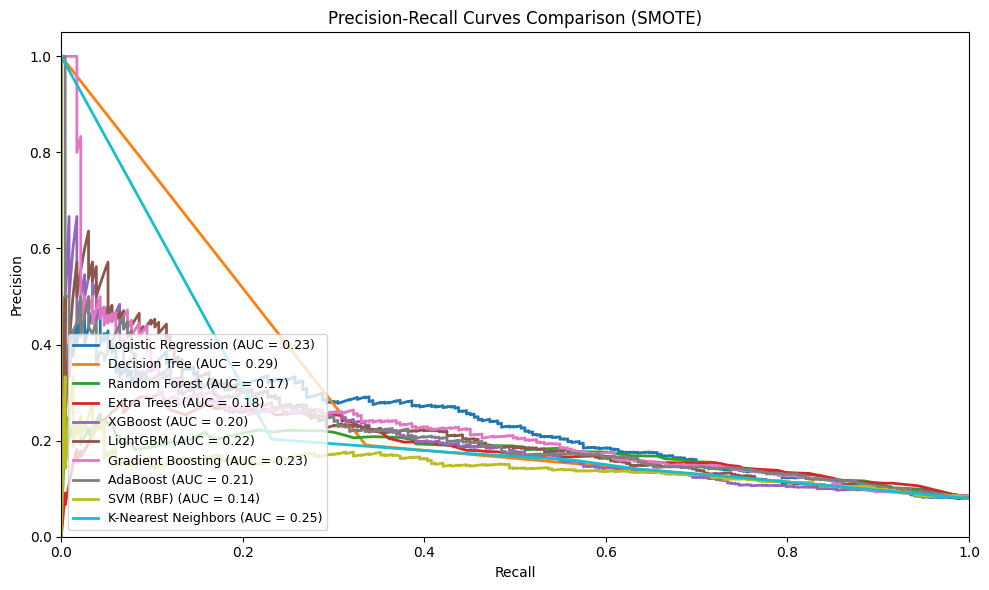

Drawing ROC Curve for Logistic Regression...
Drawing ROC Curve for Decision Tree...
Drawing ROC Curve for Random Forest...
Drawing ROC Curve for Extra Trees...
Drawing ROC Curve for XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:43:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Drawing ROC Curve for LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1772, number of negative: 1772
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000779 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3833
[LightGBM] [Info] Number of data points in the train set: 3544, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Drawing ROC Curve for Gradient Boosting...
Drawing ROC Curve for AdaBoost...
Drawing ROC Curve for SVM (RBF)...
Drawing ROC Curve for K-Nearest Neighbors...


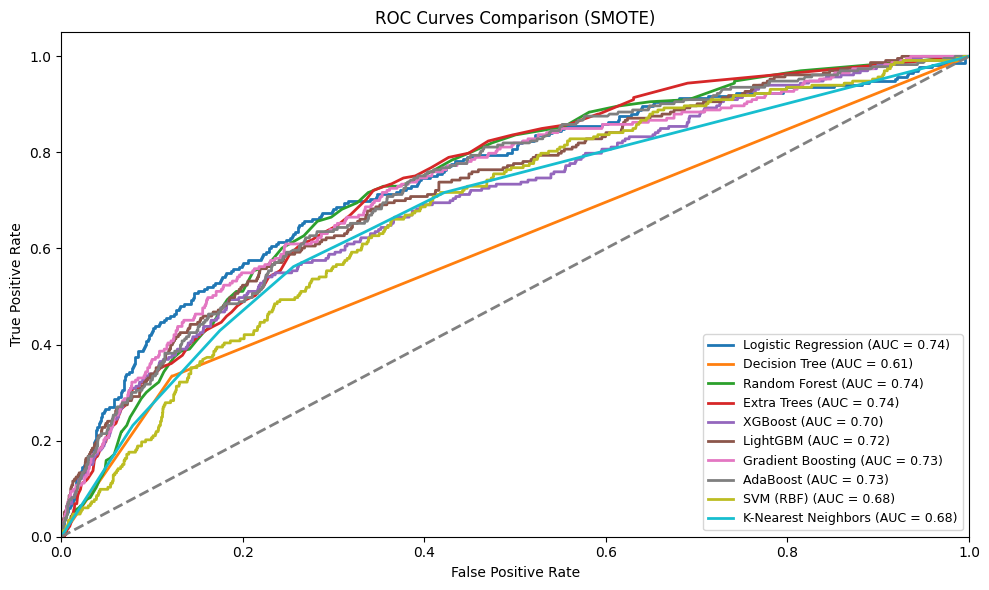

In [21]:
# 모델 이름 정리용
model_names = [m["Model"].replace(" + SMOTE", "") for m in smote_results]

# PR Curve 그리기
fig_pr, ax_pr = plt.subplots(figsize=(10, 6))

for (name, model), result in zip(models, smote_results):
    print(f"Drawing PR Curve for {name}...")

    if name in scaled_models:
        X_tr, X_val_used = X_train_sm, X_val_scaled
    else:
        X_tr, X_val_used = X_train_sm, X_val_scaled

    model.fit(X_tr, y_train_sm)
    y_pred_prob = model.predict_proba(X_val_used)[:, 1]
    precision_vals, recall_vals, _ = precision_recall_curve(y_val, y_pred_prob)
    pr_auc = auc(recall_vals, precision_vals)

    ax_pr.plot(recall_vals, precision_vals, lw=2, label=f"{name} (AUC = {pr_auc:.2f})")

ax_pr.set_xlim([0, 1])
ax_pr.set_ylim([0, 1.05])
ax_pr.set_xlabel('Recall')
ax_pr.set_ylabel('Precision')
ax_pr.set_title('Precision-Recall Curves Comparison (SMOTE)')
ax_pr.legend(loc="lower left", fontsize=9)
plt.tight_layout()
plt.savefig("5-1_PR_Curves_SMOTE.png", dpi=300)
plt.show()

# ROC Curve 그리기
fig_roc, ax_roc = plt.subplots(figsize=(10, 6))

for (name, model), result in zip(models, smote_results):
    print(f"Drawing ROC Curve for {name}...")

    if name in scaled_models:
        X_tr, X_val_used = X_train_sm, X_val_scaled
    else:
        X_tr, X_val_used = X_train_sm, X_val_scaled

    model.fit(X_tr, y_train_sm)
    y_pred_prob = model.predict_proba(X_val_used)[:, 1]
    fpr, tpr, _ = roc_curve(y_val, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    ax_roc.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {roc_auc:.2f})")

ax_roc.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
ax_roc.set_xlim([0, 1])
ax_roc.set_ylim([0, 1.05])
ax_roc.set_xlabel('False Positive Rate')
ax_roc.set_ylabel('True Positive Rate')
ax_roc.set_title('ROC Curves Comparison (SMOTE)')
ax_roc.legend(loc="lower right", fontsize=9)
plt.tight_layout()
plt.savefig("5-2_ROC_Curves_SMOTE.png", dpi=300)
plt.show()

In [22]:
files.download("5-1_PR_Curves_SMOTE.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [23]:
files.download("5-2_ROC_Curves_SMOTE.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [24]:
# Combined figure with subplots: PR on the left, ROC on the right
fig, (ax_pr, ax_roc) = plt.subplots(1, 2, figsize=(16, 8))

# Plot for each model
for (name, model) in models:
    print(f"Plotting PR/ROC for: {name}")

    # Use scaled SMOTE data for all models to ensure consistency
    X_tr = X_train_sm
    X_val_used = X_val_scaled

    # Fit and predict
    model.fit(X_tr, y_train_sm)
    y_val_pred_prob = model.predict_proba(X_val_used)[:, 1]

    # PR Curve
    precision_vals, recall_vals, _ = precision_recall_curve(y_val, y_val_pred_prob)
    pr_auc = auc(recall_vals, precision_vals)
    ax_pr.plot(recall_vals, precision_vals, lw=2, label=f"{name} (AUC = {pr_auc:.2f})")

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_val, y_val_pred_prob)
    roc_auc = auc(fpr, tpr)
    ax_roc.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {roc_auc:.2f})")

# Style PR plot (left)
ax_pr.set_xlim([0, 1])
ax_pr.set_ylim([0, 1.05])
ax_pr.set_xlabel('Recall')
ax_pr.set_ylabel('Precision')
ax_pr.set_title('Precision-Recall Curves Comparison (SMOTE)')
ax_pr.legend(loc='lower left', fontsize=9)

# Style ROC plot (right)
ax_roc.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # random guess line
ax_roc.set_xlim([0, 1])
ax_roc.set_ylim([0, 1.05])
ax_roc.set_xlabel('False Positive Rate')
ax_roc.set_ylabel('True Positive Rate')
ax_roc.set_title('Area Under the ROC Curves Comparison (SMOTE)')
ax_roc.legend(loc='lower right', fontsize=9)

plt.tight_layout()
plt.savefig("5_roc_pr_combined_smote.png", dpi=300, bbox_inches='tight')
plt.show()

Plotting PR/ROC for: Logistic Regression
Plotting PR/ROC for: Decision Tree
Plotting PR/ROC for: Random Forest
Plotting PR/ROC for: Extra Trees
Plotting PR/ROC for: XGBoost


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:44:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Plotting PR/ROC for: LightGBM
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1772, number of negative: 1772
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000816 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3833
[LightGBM] [Info] Number of data points in the train set: 3544, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Plotting PR/ROC for: Gradient Boosting
Plotting PR/ROC for: AdaBoost
Plotting PR/ROC for: SVM (RBF)
Plotting PR/ROC for: K-Nearest Neighbors


In [25]:
files.download("5_roc_pr_combined_smote.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#9. SHAP Value Calculation

In [28]:
feature_name_map = {
    "Admission source_2": "General ward (vs Emergency room)",
}

# Train the Logistic Regression model with SMOTE data
model_lr = LogisticRegression(max_iter=1000)
model_lr.fit(X_train_sm, y_train_sm)

# Create a DataFrame from the SMOTE training data and sample background data for SHAP
X_train_df = pd.DataFrame(X_train_sm, columns=X_train.columns)
background = shap.sample(X_train_df, 100, random_state=42)

# Convert scaled validation data into a DataFrame
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=X_train.columns)

X_val_scaled_df = X_val_scaled_df.rename(columns=feature_name_map)
background = background.rename(columns=feature_name_map)


# Create SHAP KernelExplainer and compute SHAP values on validation data
explainer = shap.KernelExplainer(model_lr.predict_proba, background)
shap_values = explainer.shap_values(X_val_scaled_df, nsamples=100)

# For binary classification, use only the 2D SHAP values for class 1
if isinstance(shap_values, list):
    summary_shap_values = shap_values[1]
elif shap_values.ndim == 3 and shap_values.shape[2] == 2:
    summary_shap_values = shap_values[:, :, 1]
else:
    summary_shap_values = shap_values

  0%|          | 0/2923 [00:00<?, ?it/s]

# 10. SAHP Plot - Dot, Bar, Combined

<ipython-input-29-939981fe38f9>:5: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


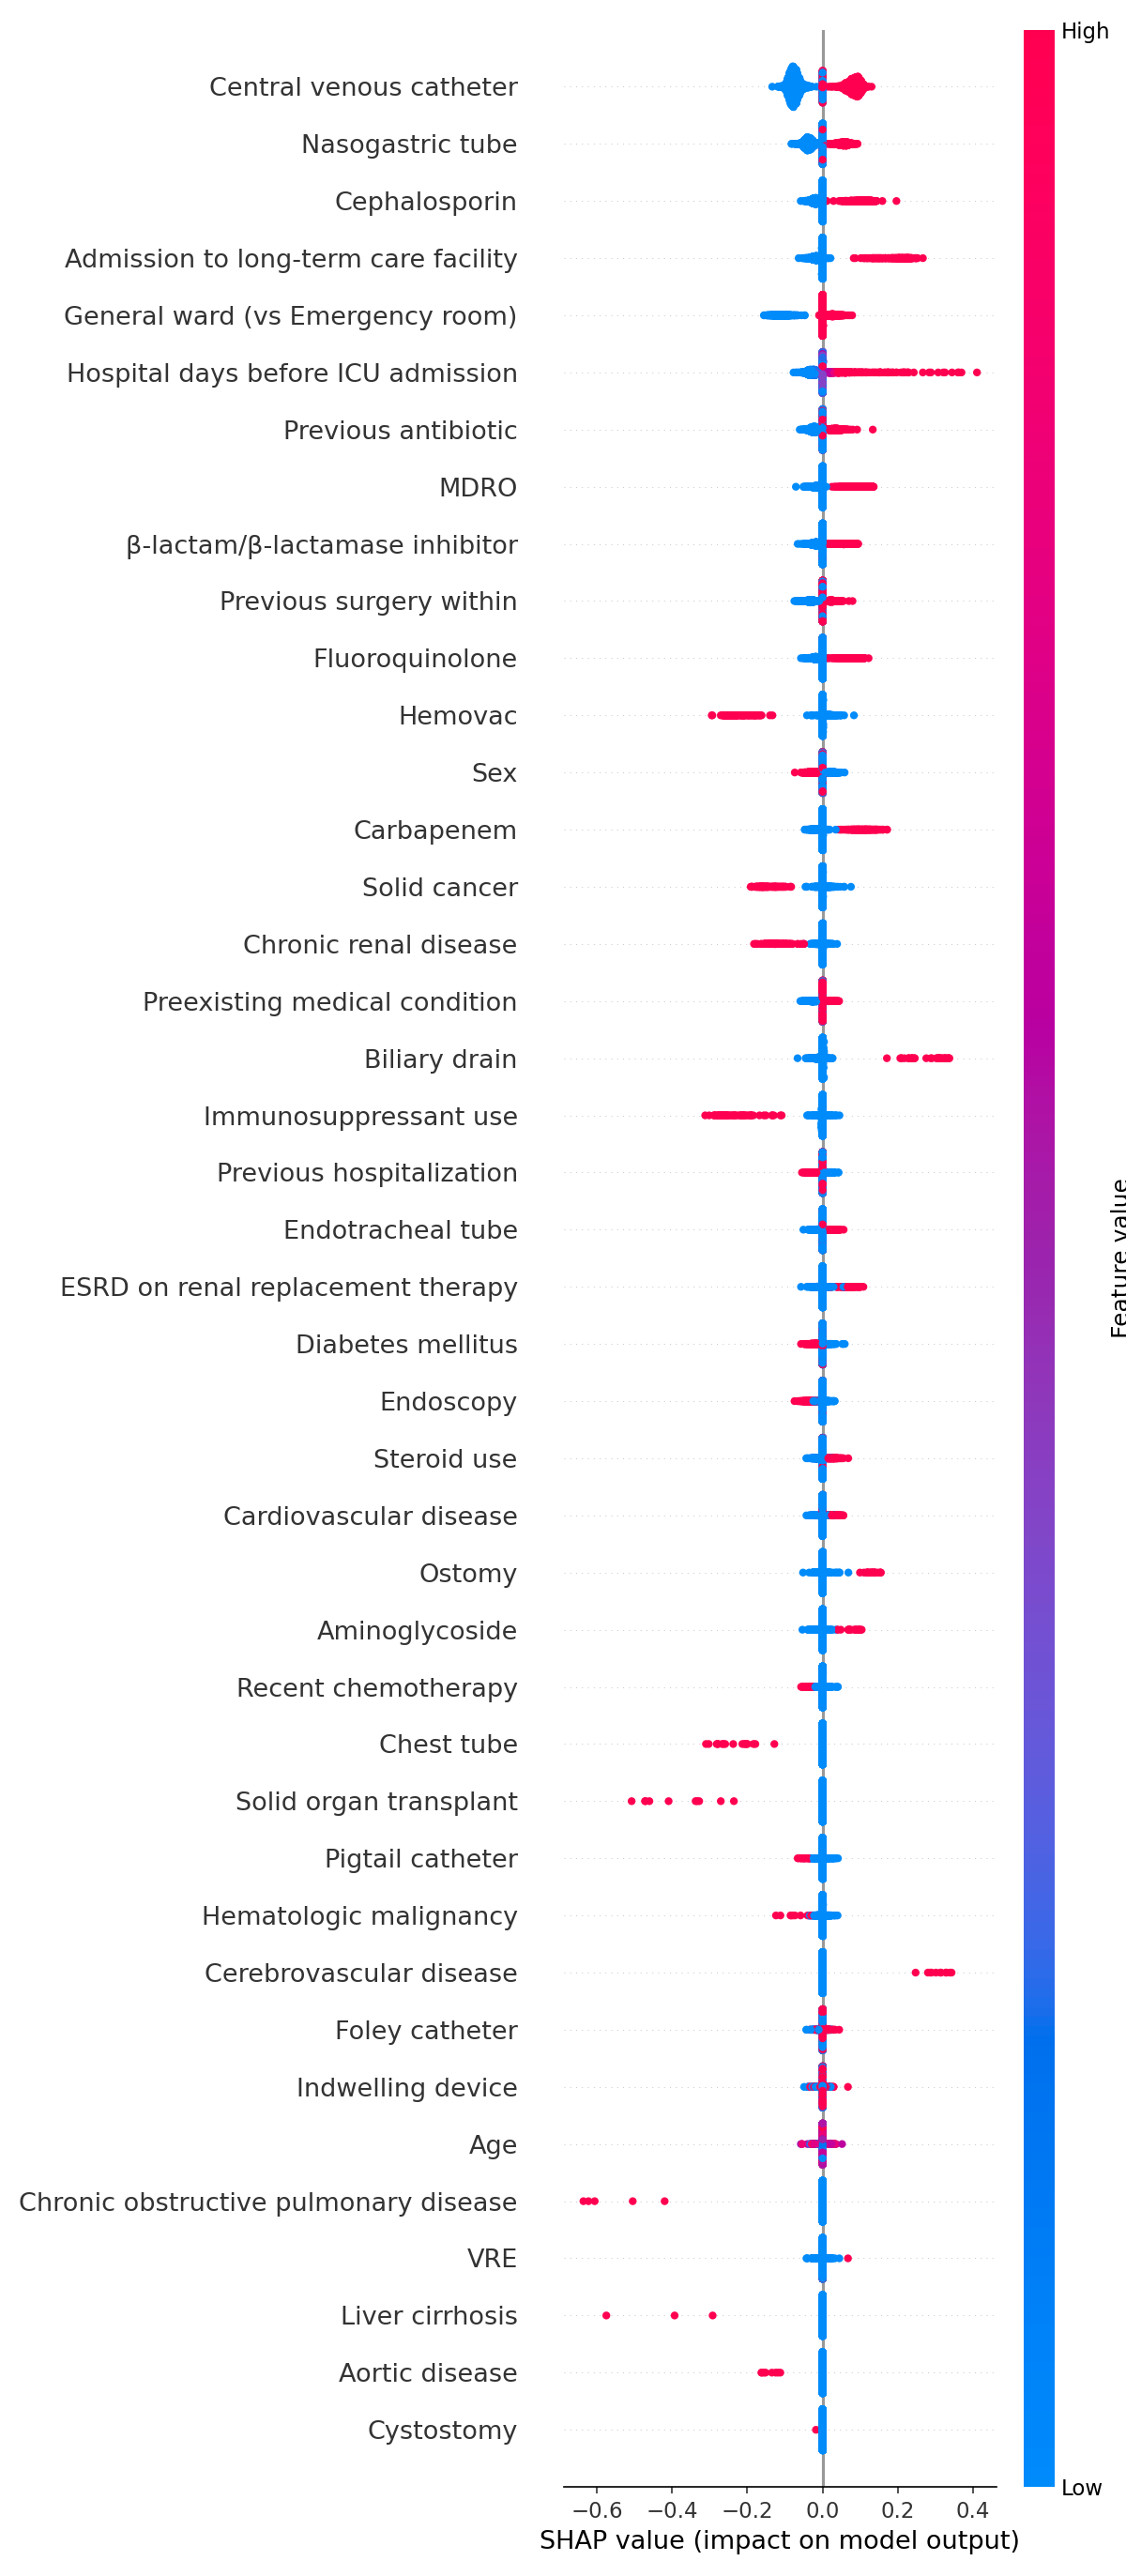

In [29]:
#Create a smaller figure for the SHAP plot
plt.figure(figsize=(6, 4))  # width=6 inches, height=4 inches

#Generate the SHAP dot plot for all features
shap.summary_plot(
    summary_shap_values,  # precomputed SHAP values (class 1 if binary)
    X_val_scaled_df,      # validation DataFrame
    plot_type="dot",      # dot plot style
    max_display=42,       # show all 42 features
    show=False            # do not display immediately
)

#Retrieve the current figure object and close it to avoid duplication
fig_dot = plt.gcf()
plt.close(fig_dot)

#Save the figure to an in-memory buffer as a PNG image
buf_dot = io.BytesIO()
fig_dot.savefig(buf_dot, format='png', dpi=150)  # set dpi if desired
buf_dot.seek(0)
img_dot = Image.open(buf_dot)

#Display the image inline in the Colab notebook
display(img_dot)


In [30]:
#Save the file locally and trigger a download
filename = "6-1_shap_dot_plot_smaller.png"
img_dot.save(filename, "PNG")
files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<ipython-input-31-52e179a79304>:4: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


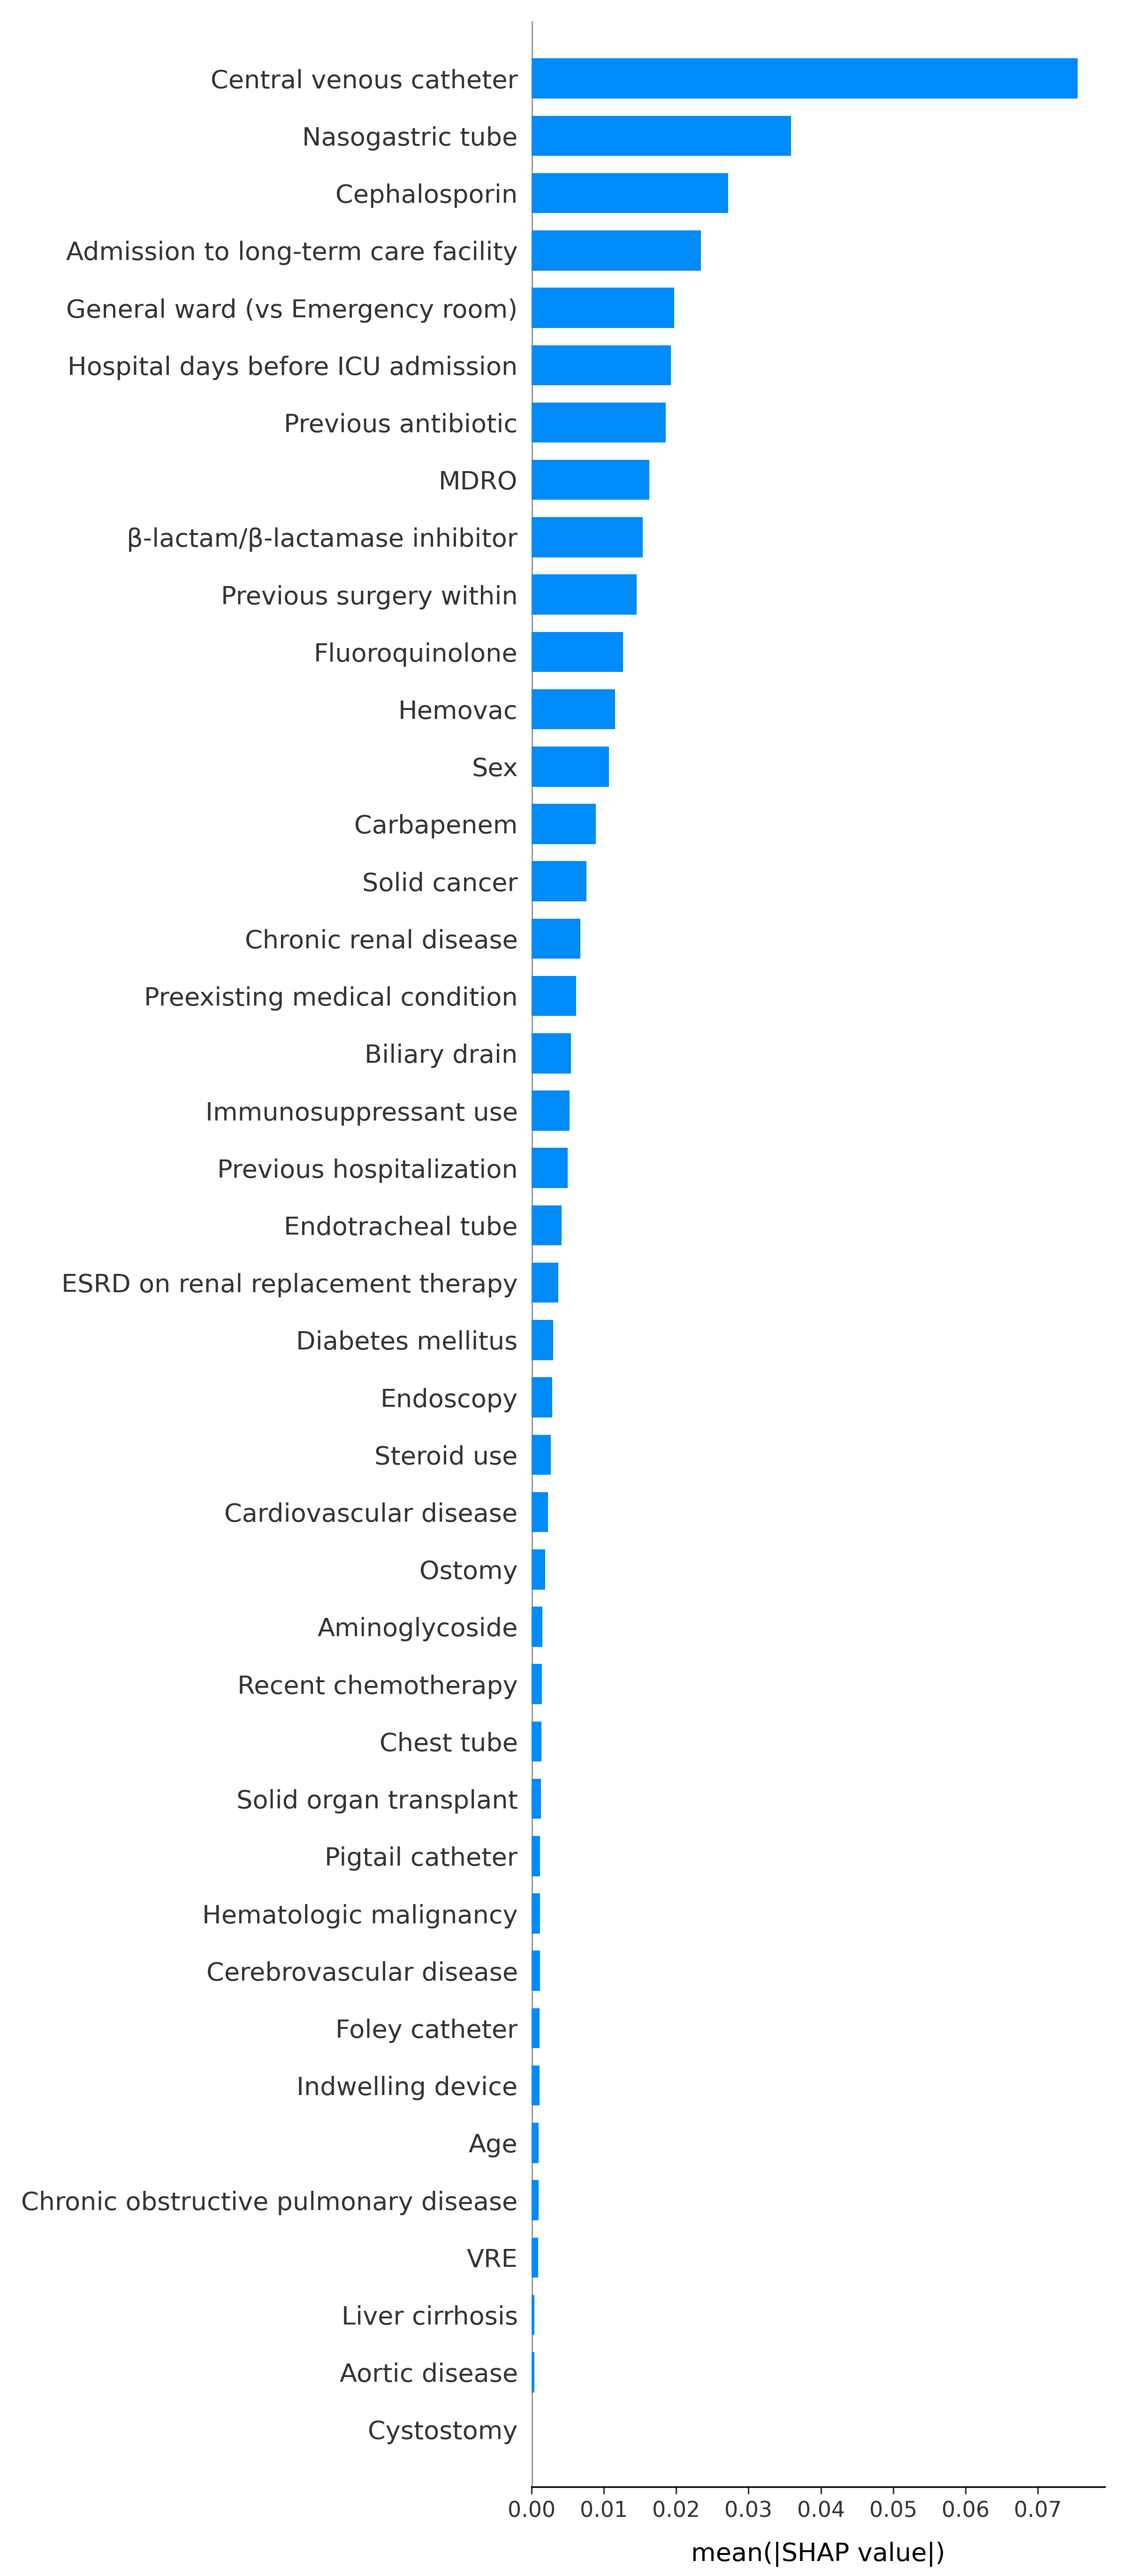

In [31]:
X_val_shap_renamed = X_val_scaled_df.rename(columns=feature_name_map)

plt.figure(figsize=(6, 4))
shap.summary_plot(
    summary_shap_values,
    X_val_scaled_df,
    plot_type="bar",     # Bar plot
    max_display=42,      # Show all 42 variables
    show=False           # Do not display immediately
)
fig_bar = plt.gcf()
ax_bar = plt.gca()
ax_bar.set_xlabel("mean(|SHAP value|)", labelpad=10)
plt.close(fig_bar)

buf_bar = io.BytesIO()
fig_bar.savefig(buf_bar, format='png', dpi=300)
buf_bar.seek(0)
img_bar = Image.open(buf_bar)

display(img_bar)

In [32]:
filename = "6-2_shap_bar_plot_smaller.png"
img_bar.save(filename, "PNG")
files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<ipython-input-33-58680eeb9a74>:3: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(
<ipython-input-33-58680eeb9a74>:20: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


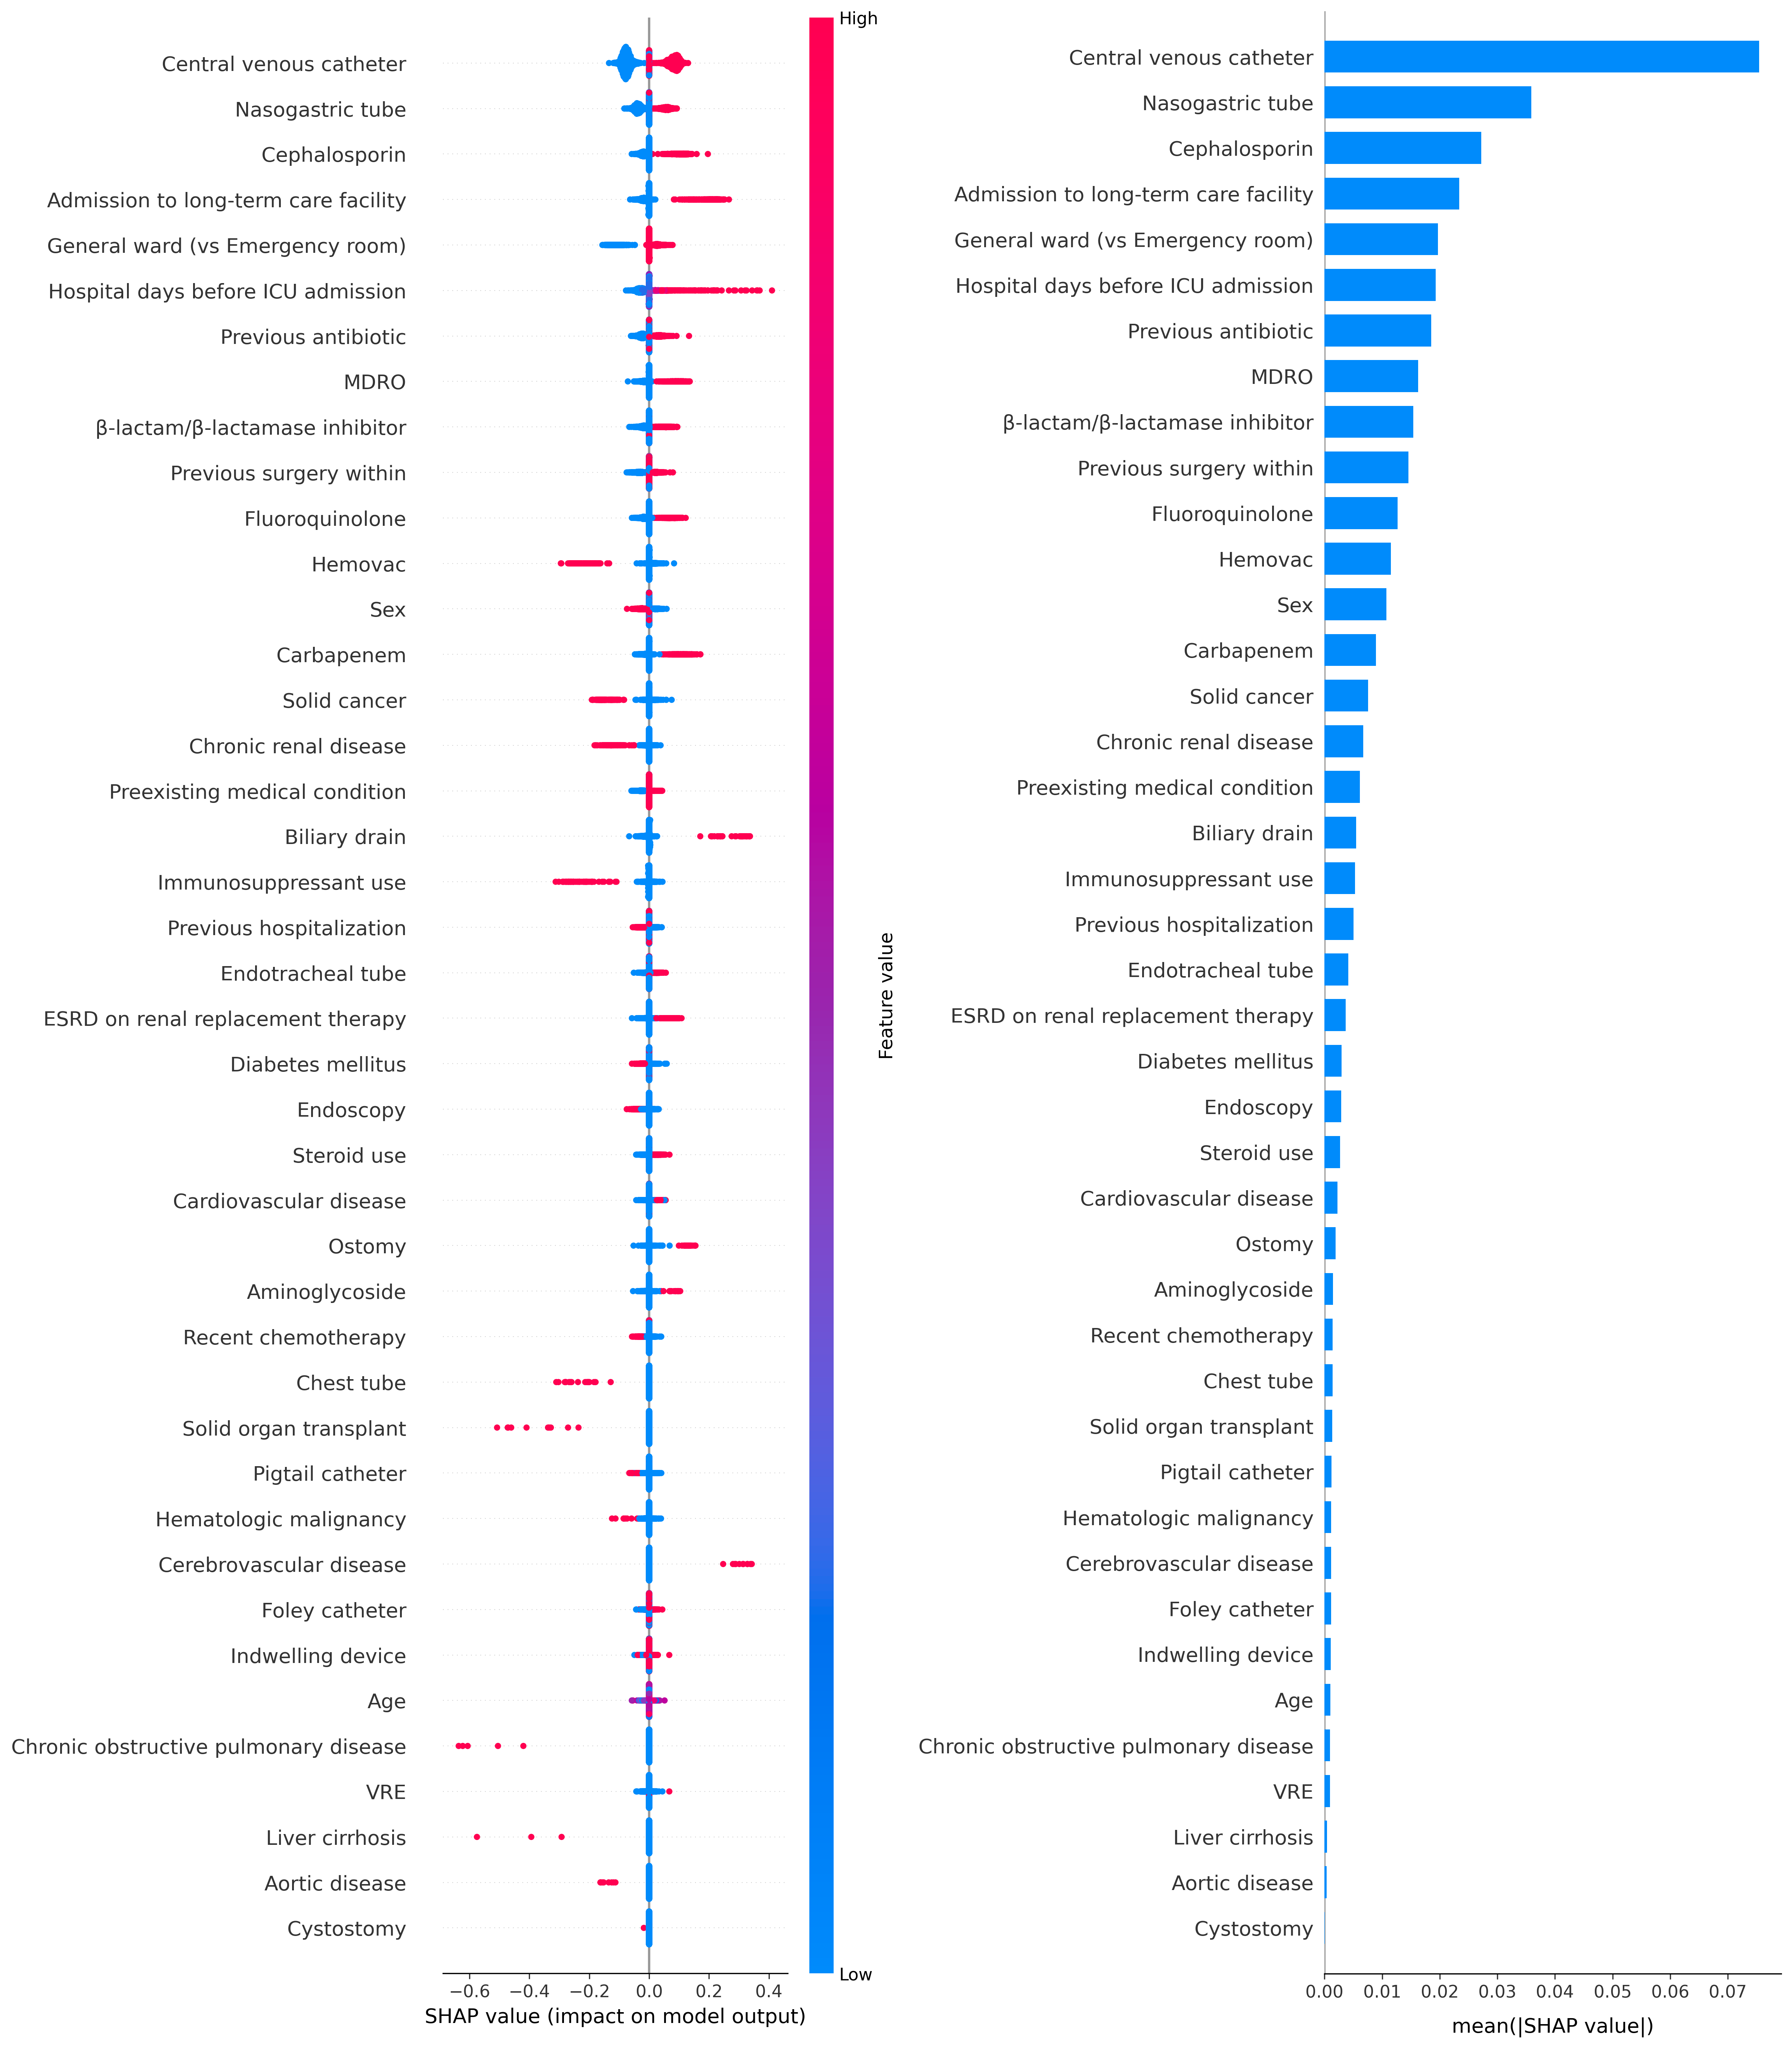

In [33]:
# Create and save SHAP dot plot
plt.figure(figsize=(5, 4))
shap.summary_plot(
    summary_shap_values,
    X_val_scaled_df,
    plot_type="dot",
    max_display=42,
    show=False
)
fig_dot = plt.gcf()
plt.close(fig_dot)

buf_dot = io.BytesIO()
fig_dot.savefig(buf_dot, format='png', dpi=300, bbox_inches='tight')
buf_dot.seek(0)
img_dot = Image.open(buf_dot)

# Create and save SHAP bar plot
plt.figure(figsize=(5, 4))
shap.summary_plot(
    summary_shap_values,
    X_val_scaled_df,
    plot_type="bar",
    max_display=42,
    show=False
)
fig_bar = plt.gcf()
ax_bar = plt.gca()
ax_bar.set_xlabel("mean(|SHAP value|)", labelpad=10)
plt.close(fig_bar)

buf_bar = io.BytesIO()
fig_bar.savefig(buf_bar, format='png', dpi=300, bbox_inches='tight')
buf_bar.seek(0)
img_bar = Image.open(buf_bar)

# Merge two plots side by side using PIL
widths = img_dot.width + img_bar.width
height = max(img_dot.height, img_bar.height)
combined_img = Image.new('RGB', (widths, height), color=(255, 255, 255))
combined_img.paste(img_dot, (0, 0))
combined_img.paste(img_bar, (img_dot.width, 0))

# Display combined image in Colab
display(combined_img)

In [34]:
# Save and download
filename = "6_shap_combined_all.png"
combined_img.save(filename)
files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 11. Coefficients from the Logistic Regression

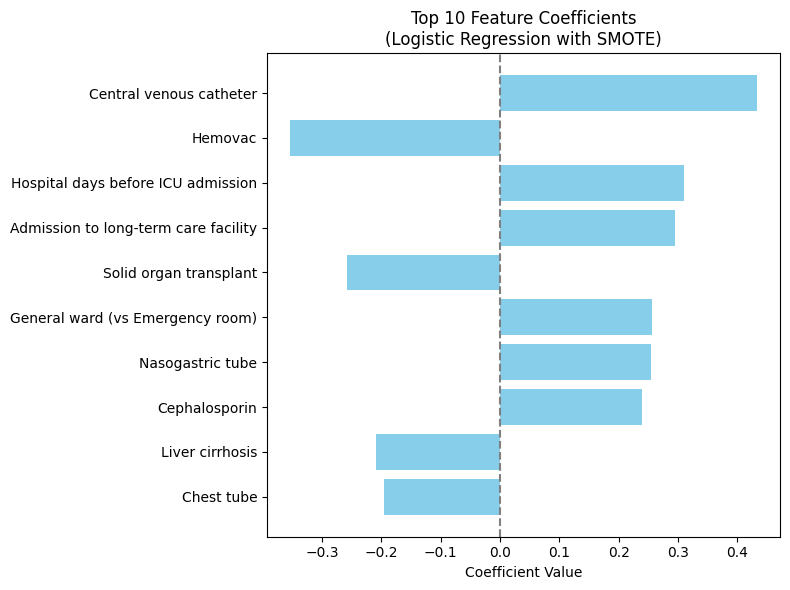

In [38]:
# Mapping to rename specific features for clarity in plots
feature_rename_map = {
    "Admission source_2": "General ward (vs Emergency room)",
    # Add more mappings here if needed
}

# Extract coefficients from trained logistic regression model (binary classification)
coefs = model_lr.coef_[0]
feature_names = X_train.columns

# Create a DataFrame with original feature names and coefficients
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefs
})

# Sort features by absolute coefficient magnitude in descending order
coef_df = coef_df.reindex(coef_df['Coefficient'].abs().sort_values(ascending=False).index)

# Select top N features (e.g., top 10) and reverse order for bar plot
top_features = coef_df.head(10).iloc[::-1]

# Rename feature names using the mapping (if applicable)
top_features['Feature'] = top_features['Feature'].apply(lambda x: feature_rename_map.get(x, x))

# Plot horizontal bar chart of top coefficients
plt.figure(figsize=(8, 6))
plt.barh(top_features['Feature'], top_features['Coefficient'], color='skyblue')
plt.axvline(x=0, color='gray', linestyle='--')  # Reference line at zero
plt.xlabel("Coefficient Value")
plt.title("Top 10 Feature Coefficients\n(Logistic Regression with SMOTE)")
plt.tight_layout()

# Save the plot as a PNG file
output_filename = "7_coefficients_bar_chart.png"
plt.savefig(output_filename, dpi=300, bbox_inches='tight')
plt.show()


In [39]:
files.download(output_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 12.Baseline characteristics of participants

# Table 1. Characteristics of patients with positive and negative CPE carriage group upon ICU admission in 2022

In [40]:
df = pd.read_excel("CPE_training_dataset_2022.xlsx")

# Convert 'CPE' column to integer (assume 1: positive, 0: negative)
df["CPE"] = df["CPE"].astype(int)

# Split the dataset into positive and negative groups based on CPE status
df_pos = df[df["CPE"] == 1]
df_neg = df[df["CPE"] == 0]


def format_continuous(series):
    """Return median (IQR) as a formatted string."""
    median = series.median()
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    return f"{median:.0f} ({q1:.0f}–{q3:.0f})"

def format_categorical(series, total):
    """Return count (percentage) for a binary variable (assumes 1 indicates 'Yes')."""
    count = series.sum()
    percent = (count / total * 100) if total > 0 else 0
    return f"{int(count)} ({percent:.1f}%)"

def format_p_value(p):
    """Return p-value formatted to 3 decimal places; show '<0.001' if p < 0.001."""
    if p < 0.001:
        return "<0.001"
    else:
        return f"{p:.3f}"


# Continuous variables
continuous_vars = [
    "Age",
    "Hospital days before ICU admission"
]

# Categorical variables (excluding "Admission source" which will be handled separately)
categorical_vars = [
    "Sex",
    "Previous hospitalization",
    "Preexisting medical condition",
    "Diabetes mellitus",
    "Chronic renal disease",
    "ESRD on renal replacement therapy",
    "Liver cirrhosis",
    "Chronic obstructive pulmonary disease",
    "Cardiovascular disease",
    "Solid cancer",
    "Hematologic malignancy",
    "Solid organ transplant",
    "Cerebrovascular disease",
    "Previous surgery within",
    "Recent chemotherapy",
    "Aortic disease",
    "Immunosuppressant use",
    "Steroid use",
    "Indwelling device",
    "Central venous catheter",
    "Foley catheter",
    "Nasogastric tube",
    "Endotracheal tube",
    "Pigtail catheter",
    "Hemovac",
    "Biliary drain",
    "Chest tube",
    "Ostomy",
    "Cystostomy",
    "Previous antibiotic",
    "Fluoroquinolone",
    "Cephalosporin",
    "Carbapenem",
    "β-lactam/β-lactamase inhibitor",
    "Aminoglycoside",
    "Admission to long-term care facility",
    "VRE",
    "MDRO",
    "Endoscopy"
]


summary_data = []

# Process continuous variables
for var in continuous_vars:
    if var not in df.columns:
        print(f"[Warning] Column '{var}' not found in DataFrame.")
        continue
    pos_value = format_continuous(df_pos[var].dropna())
    neg_value = format_continuous(df_neg[var].dropna())
    try:
        _, p_val = mannwhitneyu(df_pos[var].dropna(), df_neg[var].dropna())
    except Exception as e:
        p_val = np.nan
    summary_data.append({
        "Characteristic": var,
        f"Positive CPE carriage (n = {len(df_pos)})": pos_value,
        f"Negative CPE carriage (n = {len(df_neg)})": neg_value,
        "P value": format_p_value(p_val)
    })

# Special handling for "Admission source"
if "Admission source" in df.columns:
    # Mapping: 1 -> Emergency room, 2 -> General ward
    mapping = {1: "Emergency room", 2: "General ward"}
    total_pos = len(df_pos)
    total_neg = len(df_neg)
    try:
        contingency = pd.crosstab(df["Admission source"].dropna(), df["CPE"])
        chi2, p, dof, expected = chi2_contingency(contingency)
    except Exception as e:
        p = np.nan
    p_val_str = format_p_value(p)
    for cat in [1, 2]:
        cat_label = mapping.get(cat, str(cat))
        pos_count = (df_pos["Admission source"] == cat).sum()
        neg_count = (df_neg["Admission source"] == cat).sum()
        pos_stat = f"{int(pos_count)} ({(pos_count/total_pos*100):.1f}%)"
        neg_stat = f"{int(neg_count)} ({(neg_count/total_neg*100):.1f}%)"
        summary_data.append({
            "Characteristic": f"Admission source - {cat_label}",
            f"Positive CPE carriage (n = {total_pos})": pos_stat,
            f"Negative CPE carriage (n = {total_neg})": neg_stat,
            "P value": p_val_str
        })
else:
    print("[Warning] 'Admission source' column not found in DataFrame.")

# Process other categorical variables
for var in categorical_vars:
    if var not in df.columns:
        print(f"[Warning] Column '{var}' not found in DataFrame.")
        continue
    # Skip 'Admission source' since it's handled above
    if var == "Admission source":
        continue
    total_pos = len(df_pos)
    total_neg = len(df_neg)
    pos_stat = format_categorical(df_pos[var].dropna(), total_pos)
    neg_stat = format_categorical(df_neg[var].dropna(), total_neg)
    try:
        contingency = pd.crosstab(df[var].dropna(), df["CPE"])
        chi2, p, dof, expected = chi2_contingency(contingency)
    except Exception as e:
        p = np.nan
    summary_data.append({
        "Characteristic": var,
        f"Positive CPE carriage (n = {total_pos})": pos_stat,
        f"Negative CPE carriage (n = {total_neg})": neg_stat,
        "P value": format_p_value(p)
    })

# Create DataFrame for Table 1 and order rows
table1 = pd.DataFrame(summary_data)
ordered_list = continuous_vars + ["Admission source - Emergency room", "Admission source - General ward"] + [v for v in categorical_vars if v != "Admission source"]
table1 = table1.set_index("Characteristic").reindex(ordered_list).reset_index()

In [41]:
output_filename = "8_Table1_Characteristics.xlsx"
table1.to_excel(output_filename, index=False)
print(f"Table 1 saved to '{output_filename}'.")
display(table1)

Table 1 saved to '8_Table1_Characteristics.xlsx'.


Characteristic Positive CPE carriage (n = 220)  \
0                                     Age                      75 (62–82)   
1      Hospital days before ICU admission                         3 (1–5)   
2       Admission source - Emergency room                      26 (11.8%)   
3         Admission source - General ward                     194 (88.2%)   
4                                     Sex                      85 (38.6%)   
5                Previous hospitalization                     111 (50.5%)   
6           Preexisting medical condition                     177 (80.5%)   
7                       Diabetes mellitus                      66 (30.0%)   
8                   Chronic renal disease                       15 (6.8%)   
9       ESRD on renal replacement therapy                       17 (7.7%)   
10                        Liver cirrhosis                        0 (0.0%)   
11  Chronic obstructive pulmonary disease                        0 (0.0%)   
12                 Cardiovascular disease                      26 (11.8%)   
13                           Solid cancer                       12 (5.5%)   
14                 Hematologic malignancy                        2 (0.9%)   
15                 Solid organ transplant                        0 (0.0%)   
16                Cerebrovascular disease                        2 (0.9%)   
17                Previous surgery within                     154 (70.0%)   
18                    Recent chemotherapy                       16 (7.3%)   
19                         Aortic disease                        1 (0.5%)   
20                  Immunosuppressant use                        5 (2.3%)   
21                            Steroid use                      59 (26.8%)   
22                      Indwelling device                     191 (86.8%)   
23                Central venous catheter                     153 (69.5%)   
24                         Foley catheter                     141 (64.1%)   
25                       Nasogastric tube                     123 (55.9%)   
26                      Endotracheal tube                      78 (35.5%)   
27                       Pigtail catheter                        7 (3.2%)   
28                                Hemovac                       10 (4.5%)   
29                          Biliary drain                        6 (2.7%)   
30                             Chest tube                        4 (1.8%)   
31                                 Ostomy                        3 (1.4%)   
32                             Cystostomy                        2 (0.9%)   
33                    Previous antibiotic                     121 (55.0%)   
34                        Fluoroquinolone                      46 (20.9%)   
35                          Cephalosporin                      68 (30.9%)   
36                             Carbapenem                      33 (15.0%)   
37         β-lactam/β-lactamase inhibitor                      77 (35.0%)   
38                         Aminoglycoside                        5 (2.3%)   
39   Admission to long-term care facility                      34 (15.5%)   
40                                    VRE                        8 (3.6%)   
41                                   MDRO                      54 (24.5%)   
42                              Endoscopy                      28 (12.7%)   

   Negative CPE carriage (n = 1772) P value  
0                        72 (60–83)   0.165  
1                           2 (1–3)  <0.001  
2                       201 (11.3%)   0.923  
3                      1571 (88.7%)   0.923  
4                       770 (43.5%)   0.197  
5                       784 (44.2%)   0.094  
6                      1258 (71.0%)   0.004  
7                       487 (27.5%)   0.480  
8                         84 (4.7%)   0.241  
9                         67 (3.8%)   0.010  
10                         3 (0.2%)   1.000  
11                         1 (0.1%)   1.000  
12                       167 (9.4%)   0.

In [42]:
files.download(output_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Supplemental Table 1. Characteristics of patients with positive and negative CPE carriage group upon ICU admission in 2023

In [43]:
df_val = pd.read_excel("CPE_validation_dataset_2023.xlsx")

# Convert 'CPE' column to integer (assume 1: positive, 0: negative)
df_val["CPE"] = df_val["CPE"].astype(int)

# Split the dataset into positive and negative groups based on CPE status
df_val_pos = df_val[df_val["CPE"] == 1]
df_val_neg = df_val[df_val["CPE"] == 0]

In [44]:
def format_continuous(series):
    """Return median (IQR) as a formatted string."""
    median = series.median()
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    return f"{median:.0f} ({q1:.0f}–{q3:.0f})"

def format_categorical(series, total):
    """Return count (percentage) for a binary variable (assumes 1 indicates 'Yes')."""
    count = series.sum()
    percent = (count / total * 100) if total > 0 else 0
    return f"{int(count)} ({percent:.1f}%)"

def format_p_value(p):
    """Return p-value formatted to 3 decimal places; show '<0.001' if p < 0.001."""
    if p < 0.001:
        return "<0.001"
    else:
        return f"{p:.3f}"

# Continuous variables
continuous_vars = [
    "Age",
    "Hospital days before ICU admission"
]

# Categorical variables (excluding "Admission source" which will be handled separately)
categorical_vars = [
    "Sex",
    "Previous hospitalization",
    "Preexisting medical condition",
    "Diabetes mellitus",
    "Chronic renal disease",
    "ESRD on renal replacement therapy",
    "Liver cirrhosis",
    "Chronic obstructive pulmonary disease",
    "Cardiovascular disease",
    "Solid cancer",
    "Hematologic malignancy",
    "Solid organ transplant",
    "Cerebrovascular disease",
    "Previous surgery within",
    "Recent chemotherapy",
    "Aortic disease",
    "Immunosuppressant use",
    "Steroid use",
    "Indwelling device",
    "Central venous catheter",
    "Foley catheter",
    "Nasogastric tube",
    "Endotracheal tube",
    "Pigtail catheter",
    "Hemovac",
    "Biliary drain",
    "Chest tube",
    "Ostomy",
    "Cystostomy",
    "Previous antibiotic",
    "Fluoroquinolone",
    "Cephalosporin",
    "Carbapenem",
    "β-lactam/β-lactamase inhibitor",
    "Aminoglycoside",
    "Admission to long-term care facility",
    "VRE",
    "MDRO",
    "Endoscopy"
]

summary_data = []

for var in continuous_vars:
    if var not in df_val.columns:
        print(f"[Warning] Column '{var}' not found in validation DataFrame.")
        continue
    pos_value = format_continuous(df_val_pos[var].dropna())
    neg_value = format_continuous(df_val_neg[var].dropna())
    try:
        _, p_val = mannwhitneyu(df_val_pos[var].dropna(), df_val_neg[var].dropna())
    except Exception as e:
        p_val = np.nan
    summary_data.append({
        "Characteristic": var,
        f"Positive CPE carriage (n = {len(df_val_pos)})": pos_value,
        f"Negative CPE carriage (n = {len(df_val_neg)})": neg_value,
        "P value": format_p_value(p_val)
    })


if "Admission source" in df_val.columns:
    # Mapping: 1 -> Emergency room, 2 -> General ward
    mapping = {1: "Emergency room", 2: "General ward"}
    total_pos = len(df_val_pos)
    total_neg = len(df_val_neg)
    try:
        contingency = pd.crosstab(df_val["Admission source"].dropna(), df_val["CPE"])
        chi2, p, dof, expected = chi2_contingency(contingency)
    except Exception as e:
        p = np.nan
    p_val_str = format_p_value(p)
    for cat in [1, 2]:
        cat_label = mapping.get(cat, str(cat))
        pos_count = (df_val_pos["Admission source"] == cat).sum()
        neg_count = (df_val_neg["Admission source"] == cat).sum()
        pos_stat = f"{int(pos_count)} ({(pos_count/total_pos*100):.1f}%)"
        neg_stat = f"{int(neg_count)} ({(neg_count/total_neg*100):.1f}%)"
        summary_data.append({
            "Characteristic": f"Admission source - {cat_label}",
            f"Positive CPE carriage (n = {total_pos})": pos_stat,
            f"Negative CPE carriage (n = {total_neg})": neg_stat,
            "P value": p_val_str
        })
else:
    print("[Warning] 'Admission source' column not found in validation DataFrame.")


for var in categorical_vars:
    if var not in df_val.columns:
        print(f"[Warning] Column '{var}' not found in validation DataFrame.")
        continue
    if var == "Admission source":
        continue  # already handled
    total_pos = len(df_val_pos)
    total_neg = len(df_val_neg)
    pos_stat = format_categorical(df_val_pos[var].dropna(), total_pos)
    neg_stat = format_categorical(df_val_neg[var].dropna(), total_neg)
    try:
        contingency = pd.crosstab(df_val[var].dropna(), df_val["CPE"])
        chi2, p, dof, expected = chi2_contingency(contingency)
    except Exception as e:
        p = np.nan
    summary_data.append({
        "Characteristic": var,
        f"Positive CPE carriage (n = {total_pos})": pos_stat,
        f"Negative CPE carriage (n = {total_neg})": neg_stat,
        "P value": format_p_value(p)
    })


table1_val = pd.DataFrame(summary_data)

# Order rows: continuous variables first, then Admission source rows, then remaining categorical variables
ordered_list = continuous_vars + ["Admission source - Emergency room", "Admission source - General ward"] + [v for v in categorical_vars if v != "Admission source"]
table1_val = table1_val.set_index("Characteristic").reindex(ordered_list).reset_index()

output_filename_val = "9_Supplementary_material_1_Characteristics.xlsx"
table1_val.to_excel(output_filename_val, index=False)
print(f"Supplementary Table 1 saved to '{output_filename_val}'.")
display(table1_val)

Supplementary Table 1 saved to '9_Supplementary_material_1_Characteristics.xlsx'.


Characteristic Positive CPE carriage (n = 233)  \
0                                     Age                      76 (64–83)   
1      Hospital days before ICU admission                         2 (1–4)   
2       Admission source - Emergency room                      24 (10.3%)   
3         Admission source - General ward                     209 (89.7%)   
4                                     Sex                     104 (44.6%)   
5                Previous hospitalization                     121 (51.9%)   
6           Preexisting medical condition                     186 (79.8%)   
7                       Diabetes mellitus                      82 (35.2%)   
8                   Chronic renal disease                      24 (10.3%)   
9       ESRD on renal replacement therapy                       23 (9.9%)   
10                        Liver cirrhosis                        0 (0.0%)   
11  Chronic obstructive pulmonary disease                        2 (0.9%)   
12                 Cardiovascular disease                       21 (9.0%)   
13                           Solid cancer                       17 (7.3%)   
14                 Hematologic malignancy                        3 (1.3%)   
15                 Solid organ transplant                        1 (0.4%)   
16                Cerebrovascular disease                        0 (0.0%)   
17                Previous surgery within                     158 (67.8%)   
18                    Recent chemotherapy                       20 (8.6%)   
19                         Aortic disease                        0 (0.0%)   
20                  Immunosuppressant use                       10 (4.3%)   
21                            Steroid use                      74 (31.8%)   
22                      Indwelling device                     190 (81.5%)   
23                Central venous catheter                     125 (53.6%)   
24                         Foley catheter                     127 (54.5%)   
25                       Nasogastric tube                     102 (43.8%)   
26                      Endotracheal tube                      55 (23.6%)   
27                       Pigtail catheter                        6 (2.6%)   
28                                Hemovac                       11 (4.7%)   
29                          Biliary drain                        8 (3.4%)   
30                             Chest tube                        3 (1.3%)   
31                                 Ostomy                        3 (1.3%)   
32                             Cystostomy                        1 (0.4%)   
33                    Previous antibiotic                     138 (59.2%)   
34                        Fluoroquinolone                      54 (23.2%)   
35                          Cephalosporin                      78 (33.5%)   
36                             Carbapenem                      59 (25.3%)   
37         β-lactam/β-lactamase inhibitor                     104 (44.6%)   
38                         Aminoglycoside                        9 (3.9%)   
39   Admission to long-term care facility                      57 (24.5%)   
40                                    VRE                       22 (9.4%)   
41                                   MDRO                     100 (42.9%)   
42                              Endoscopy                      47 (20.2%)   

   Negative CPE carriage (n = 2690) P value  
0                        72 (60–83)   0.087  
1                           2 (1–3)  <0.001  
2                       307 (11.4%)   0.685  
3                      2383 (88.6%)   0.685  
4                      1186 (44.1%)   0.927  
5                      1209 (44.9%)   0.047  
6                      1899 (70.6%)   0.004  
7                       681 (25.3%)   0.001  
8                        126 (4.7%)  <0.001  
9                        108 (4.0%)  <0.001  
10                         3 (0.1%)   1.000  
11                         3 (0.1%)   0.069  
12                       259 (9.6%)   0.

In [45]:
# Download the Excel file
files.download(output_filename_val)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>